# **Microsoft Malware Prediction**

#### Objetivo

El objetivo es predecir la probabilidad de que una máquina Windows se infecte con diversas familias de malware, basándose en sus diferentes propiedades. Los datos de telemetría que contienen estas propiedades y las infecciones de la máquina se generaron combinando informes de latidos y amenazas recopilados por Windows Defender, la solución de protección de endpoints de Microsoft.

Cada fila de este conjunto de datos corresponde a una máquina, identificada de forma única mediante un MachineIdentifier. HasDetectionses la información de base e indica que se detectó malware en la máquina.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mw_df = pd.read_csv('train.csv', low_memory=False)
mw_df

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921478,ffffedfe8fcc46e6d36ab39953589fee,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1555.0,0,7.0,0,NaN,53447.0,...,63069.0,1,NaN,0.0,0,0,0.0,0.0,5.0,1
8921479,ffffef606490b2970873ec0a27ebd24b,win8defender,1.1.13303.0,4.9.10586.672,1.233.4218.0,0,7.0,0,1078.0,59914.0,...,NaN,0,0.0,0.0,0,0,0.0,0.0,5.0,0
8921480,fffff8a40070d2d8379bb7fa2ed2fa66,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1242.0,0,7.0,0,NaN,53447.0,...,71061.0,1,NaN,0.0,0,0,0.0,0.0,7.0,1
8921481,fffffbbaaf5969ae4b93e7f3f6d7132f,win8defender,1.1.14901.4,4.16.17656.18052,1.269.1834.0,0,7.0,0,NaN,6630.0,...,33142.0,1,NaN,0.0,0,0,0.0,0.0,13.0,1


In [3]:
mw_df.shape

(8921483, 83)

In [4]:
mw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   MachineIdentifier                                  object 
 1   ProductName                                        object 
 2   EngineVersion                                      object 
 3   AppVersion                                         object 
 4   AvSigVersion                                       object 
 5   IsBeta                                             int64  
 6   RtpStateBitfield                                   float64
 7   IsSxsPassiveMode                                   int64  
 8   DefaultBrowsersIdentifier                          float64
 9   AVProductStatesIdentifier                          float64
 10  AVProductsInstalled                                float64
 11  AVProductsEnabled                                 

Al inspeccionar el DataFrame completo vemos que tiene demasiadas filas, voy a extraer una porción suficientemente grande y al azar para nuestro propósito. Por ejemplo, seleccionaré 200.000 registros al azar.

A continuación, volcamos esta muestra en un nuevo archivo CSV llamado train_reducido.csv, y a partir de ahí trabajaré con este subconjunto.

In [5]:
mw_df = mw_df.sample(n=200000, random_state=42).reset_index(drop=True)
mw_df.to_csv('train_reducido.csv', index=False)

A continuación, cargamos el DataFrame de la muestra extraída del conjunto original. Antes de ello, habíamos asignado a cada columna el tipo de dato más adecuado para optimizar el uso de memoria y el rendimiento.

In [6]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
        }

In [7]:
mw_df_reducido = pd.read_csv('train_reducido.csv', low_memory=False, dtype=dtypes)
mw_df_reducido.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,...,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1
1,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,...,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0
2,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,...,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0
3,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,...,48473.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1
4,06ca8fa8d32c2abdc5b3577d676b3269,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,0,7.0,0,NaN,47238.0,...,4343.0,1,NaN,0.0,1,0,0.0,1.0,13.0,1


In [8]:
mw_df_reducido.shape

(200000, 83)

El Dataframe tiene 200.000 filas y 83 columnas

Cada fila representa una máquina única identificada por MachineIdentifier. Para comprobarlo, deberíamos encontrar 200.000 valores distintos en esa columna.

In [9]:
mw_df_reducido.MachineIdentifier.nunique() == len(mw_df_reducido)

True

In [10]:
primary_key = 'MachineIdentifier'

Correcto, hay 200.000 valores unicos para esta columna, cada observación representa una unica maquina. La variable MachineIdentifier es la clave primaria.

El objetivo con este problema de clasificación es predecir el valor de la columna HasDetections. Dicha variable toma el valor 1 si se ha detectado malware en la máquina, o 0 si la maquina no tiene malware.

In [11]:
target_variable = 'HasDetections'

In [12]:
mw_df_reducido[target_variable].value_counts()

HasDetections
1    100132
0     99868
Name: count, dtype: int64

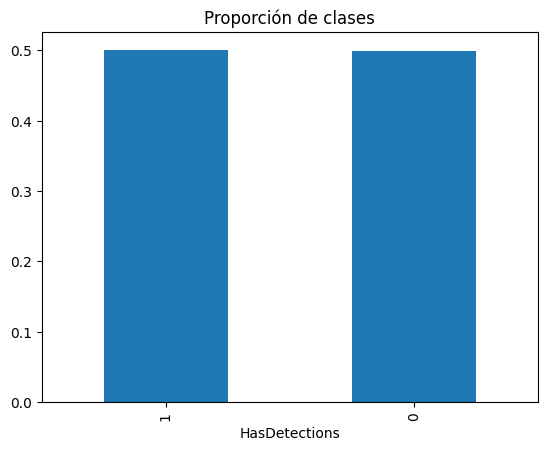

In [13]:
mw_df_reducido['HasDetections'].value_counts(normalize=True).plot(kind='bar')
plt.title('Proporción de clases')
plt.show()

In [14]:
mw_df_reducido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   MachineIdentifier                                  200000 non-null  category
 1   ProductName                                        200000 non-null  category
 2   EngineVersion                                      200000 non-null  category
 3   AppVersion                                         200000 non-null  category
 4   AvSigVersion                                       200000 non-null  category
 5   IsBeta                                             200000 non-null  int8    
 6   RtpStateBitfield                                   199255 non-null  float32 
 7   IsSxsPassiveMode                                   200000 non-null  int8    
 8   DefaultBrowsersIdentifier                          9514 non-null

### Hay 30 variables categoricas y float32(36), int16(5), int32(1), int8(11), por lo tanto, 53 variables numericas.

# Estudio de variables y nulos

In [15]:
mw_df_reducido.isnull().mean().sort_values(ascending=False)

PuaMode                         0.999750
Census_ProcessorClass           0.995995
DefaultBrowsersIdentifier       0.952430
Census_IsFlightingInternal      0.830125
Census_InternalBatteryType      0.711690
                                  ...   
ProductName                     0.000000
Census_HasOpticalDiskDrive      0.000000
Census_PowerPlatformRoleName    0.000000
Census_OSVersion                0.000000
HasDetections                   0.000000
Length: 83, dtype: float64

In [16]:
missing_pct = mw_df_reducido.isnull().mean().mul(100)
missing_threshold = 60.0
cols_to_drop = missing_pct[missing_pct > missing_threshold].index
lista_var_eliminar_nan = cols_to_drop.tolist()
lista_var_eliminar_nan

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

In [17]:
mw_df_reducido.drop(columns=cols_to_drop, inplace=True)


In [18]:
mw_df_reducido.shape

(200000, 76)

Variables del dataset constantes

In [19]:
constant_columns = [
    col
    for col in mw_df_reducido.columns
    if mw_df_reducido[col].nunique(dropna=False) == 1
]
constant_columns

['IsBeta']

In [20]:
mw_df_reducido.IsBeta.value_counts(normalize=True, dropna=False)

IsBeta
0    1.0
Name: proportion, dtype: float64

Se elimina la variable IsBeta porque es constante (solo toma valor 0) y no aporta ninguna información al modelo.

In [21]:
mw_df_reducido.drop(columns = constant_columns, inplace=True)

In [22]:
mw_df_reducido.shape

(200000, 75)

Voy a analizar las variables de baja varianza

In [23]:
variance_threshold = 0.96
low_variance_cols = []
for col in mw_df_reducido.columns:
    top_freq = mw_df_reducido[col].value_counts(normalize=True, dropna=False).iloc[0]
    if top_freq > variance_threshold:
        low_variance_cols.append(col)
low_variance_cols

['ProductName',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductsEnabled',
 'HasTpm',
 'Platform',
 'OsVer',
 'AutoSampleOptIn',
 'Firewall',
 'UacLuaenable',
 'Census_DeviceFamily',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsVirtualDevice',
 'Census_IsPenCapable']

Como estas columnas tienen siempre (o casi siempre) el mismo valor, no aportan información al modelo y conviene eliminarlas.

# Correlación de las variables numericas de baja varianza

In [24]:
low_varianza_numeric = mw_df_reducido[low_variance_cols].select_dtypes(include=['number']).columns.tolist()
correlation_with_target = mw_df_reducido[low_varianza_numeric + [target_variable]].corr()[target_variable].sort_values(ascending=False)
correlation_with_target

HasDetections                       1.000000
RtpStateBitfield                    0.038960
HasTpm                              0.007742
UacLuaenable                        0.005457
Firewall                            0.004653
Census_IsPortableOperatingSystem    0.001797
AutoSampleOptIn                    -0.001007
Census_IsFlightsDisabled           -0.003912
Census_IsPenCapable                -0.017156
IsSxsPassiveMode                   -0.034447
AVProductsEnabled                  -0.042275
Census_IsVirtualDevice             -0.050570
Name: HasDetections, dtype: float64

# Correlación de las variables categóricas de baja varianza

In [25]:
low_varianza_category = mw_df_reducido[low_variance_cols].select_dtypes(include=['category']).columns.tolist()
low_varianza_category

['ProductName', 'Platform', 'OsVer', 'Census_DeviceFamily']

In [26]:
low_varianza_category = ['ProductName', 'Platform', 'OsVer', 'Census_DeviceFamily']
codes = mw_df_reducido[low_varianza_category].apply(lambda s: s.cat.codes)
codes['HasDetections'] = mw_df_reducido['HasDetections']
corr = codes.corr()['HasDetections'].abs().sort_values(ascending=False)
corr


HasDetections          1.000000
Census_DeviceFamily    0.011988
ProductName            0.004899
OsVer                  0.000985
Platform               0.000701
Name: HasDetections, dtype: float64

Se puede observar que las variables categoricas y numericas seleccionadas, no tienen una correlación fuerte entre dichas variables y la variable objetivo. Por lo tanto, se confirma, se pueden eliminar.

In [27]:
mw_df_reducido.drop(columns=low_variance_cols, inplace=True)

In [28]:
mw_df_reducido.shape

(200000, 60)

# Preprocesamiento de datos

In [29]:
mw_df_reducido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 60 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   MachineIdentifier                                  200000 non-null  category
 1   EngineVersion                                      200000 non-null  category
 2   AppVersion                                         200000 non-null  category
 3   AvSigVersion                                       200000 non-null  category
 4   AVProductStatesIdentifier                          199238 non-null  float32 
 5   AVProductsInstalled                                199238 non-null  float32 
 6   CountryIdentifier                                  200000 non-null  int16   
 7   CityIdentifier                                     192702 non-null  float32 
 8   OrganizationIdentifier                             138255 non-nu

In [30]:
mw_df_reducido.shape

(200000, 60)

# Identificación de tipos

Antes de seguir, comprobamos cuántas variables numéricas y cuántas categóricas tenemos

In [31]:
lista_var_num = mw_df_reducido.select_dtypes(include=['number']).columns.tolist()
lista_var_cat = mw_df_reducido.select_dtypes(include=['category','object']).columns.tolist()
print(f"{len(lista_var_num)} numéricas, {len(lista_var_cat)} categóricas")

37 numéricas, 23 categóricas


**Convertir variables numéricas a categóricas**  
Algunas columnas parecen “numéricas” porque contienen dígitos, pero en realidad son **códigos** o **etiquetas discretas** (IDs, versiones, banderas). No tienen significado de magnitud continua, por lo que:

In [32]:
lista_var_num_a_categoricas = [
 'AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IeVerIdentifier',
 'LocaleEnglishNameIdentifier',
 'Wdft_RegionIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier'
 ]

In [33]:
mw_df_reducido[lista_var_num_a_categoricas].dtypes

AVProductStatesIdentifier                 float32
CountryIdentifier                           int16
CityIdentifier                            float32
OrganizationIdentifier                    float32
GeoNameIdentifier                         float32
OsBuild                                     int16
OsSuite                                     int16
IeVerIdentifier                           float32
LocaleEnglishNameIdentifier                  int8
Wdft_RegionIdentifier                     float32
Census_ProcessorManufacturerIdentifier    float32
Census_OEMNameIdentifier                  float32
Census_OEMModelIdentifier                 float32
Census_ProcessorModelIdentifier           float32
Census_OSBuildNumber                        int16
Census_OSBuildRevision                      int32
Census_OSInstallLanguageIdentifier        float32
Census_OSUILocaleIdentifier                 int16
Census_FirmwareManufacturerIdentifier     float32
Census_FirmwareVersionIdentifier          float32


In [34]:
len(lista_var_num_a_categoricas)

20

Estas columnas contienen códigos discretos (identificadores, flags) y no valores continuos. Por ello las convertimos a categoricas

In [35]:
mw_df_reducido[lista_var_num_a_categoricas] = mw_df_reducido[lista_var_num_a_categoricas].astype('category')

In [36]:
lista_var_num = mw_df_reducido.select_dtypes(include=['number']).columns.tolist()
lista_var_cat = mw_df_reducido.select_dtypes(include=['category','object']).columns.tolist()
print(f"{len(lista_var_num)} numéricas, {len(lista_var_cat)} categóricas")

17 numéricas, 43 categóricas


In [37]:
for col in lista_var_num:
    n_uni = mw_df_reducido[col].nunique(dropna=False)
    print(f"{col}: {n_uni} valores únicos")

AVProductsInstalled: 6 valores únicos
IsProtected: 3 valores únicos
SMode: 3 valores únicos
Census_ProcessorCoreCount: 25 valores únicos
Census_PrimaryDiskTotalCapacity: 653 valores únicos
Census_SystemVolumeTotalCapacity: 76507 valores únicos
Census_HasOpticalDiskDrive: 2 valores únicos
Census_TotalPhysicalRAM: 296 valores únicos
Census_InternalPrimaryDiagonalDisplaySizeInInches: 429 valores únicos
Census_InternalPrimaryDisplayResolutionHorizontal: 240 valores únicos
Census_InternalPrimaryDisplayResolutionVertical: 276 valores únicos
Census_InternalBatteryNumberOfCharges: 2696 valores únicos
Census_IsSecureBootEnabled: 2 valores únicos
Census_IsTouchEnabled: 2 valores únicos
Census_IsAlwaysOnAlwaysConnectedCapable: 3 valores únicos
Wdft_IsGamer: 3 valores únicos
HasDetections: 2 valores únicos


Hay 17 variables numericas, entre ellas, hay 8 con ≤ 10 valores únicos (incluyendo el target).

In [38]:
to_cat = [
    col for col in lista_var_num
    if mw_df_reducido[col].nunique(dropna=False) <= 10
]
print("Variables a convertir a category:", to_cat)
mw_df_reducido[to_cat] = mw_df_reducido[to_cat].astype('category')

Variables a convertir a category: ['AVProductsInstalled', 'IsProtected', 'SMode', 'Census_HasOpticalDiskDrive', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 'HasDetections']


In [39]:
lista_var_num = mw_df_reducido.select_dtypes(include=['number']).columns.tolist()
lista_var_cat = mw_df_reducido.select_dtypes(include=['category','object']).columns.tolist()
print(f"{len(lista_var_num)} numéricas, {len(lista_var_cat)} categóricas")

8 numéricas, 52 categóricas


In [40]:
lista_var_num

['Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges']

In [41]:
mw_df_reducido.describe()[lista_var_num]

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
count,199065.000000,1.988110e+05,1.988110e+05,198213.000000,198939.000000,198940.000000,198940.000000,1.940030e+05
mean,3.995122,5.138132e+05,3.780607e+05,6130.501465,16.700275,1547.501953,897.979309,1.132902e+09
std,2.096347,3.693045e+05,3.373383e+05,4912.063477,5.970040,367.426514,214.221558,1.894571e+09
min,1.000000,1.024000e+04,9.689000e+03,512.000000,4.900000,-1.000000,-1.000000,0.000000e+00
25%,2.000000,2.384750e+05,1.207510e+05,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00
50%,4.000000,4.769400e+05,2.494340e+05,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00
75%,4.000000,9.538690e+05,4.759970e+05,8192.000000,17.299999,1920.000000,1080.000000,4.294967e+09
max,88.000000,2.859591e+07,2.859558e+07,262144.000000,142.000000,11520.000000,4320.000000,4.294967e+09


**Tratamiento detallado de las variables continuas restantes**  

- **Census_ProcessorCoreCount**: número de núcleos CPU (1–88). No hay valores negativos; imputamos la mediana y escalamos.  
- **Census_PrimaryDiskTotalCapacity**: capacidad de disco en bytes (~10 KB–28 GB). Muy sesgada; tras imputar mediana, la escalamos.  
- **Census_SystemVolumeTotalCapacity**: similar a `PrimaryDisk`, mide la unidad de sistema; mismo tratamiento.  
- **Census_TotalPhysicalRAM**: RAM en MB (512–262 144). Outliers altos; opcionalmente winsorizamos al 1–99 % antes de escalar.  
- **Census_InternalPrimaryDiagonalDisplaySizeInInches**: tamaño de pantalla en pulgadas (4.9–142). Rango plausible, imputamos mediana y escalamos.  
- **Census_InternalPrimaryDisplayResolutionHorizontal**: píxeles horizontales; `-1` marca “desconocido”. Reemplazamos `-1` por NaN, luego imputamos mediana y escalamos.  
- **Census_InternalPrimaryDisplayResolutionVertical**: píxeles verticales; idéntico al horizontal (reemplazo de `-1` ➔ NaN y luego imputación).  
- **Census_InternalBatteryNumberOfCharges**: número de ciclos de carga; `0` en equipos sin batería y valores extremos (~4 294 967 295). Winsorizamos al 1–99 % y escalamos. 

In [42]:
nulos = mw_df_reducido[lista_var_num].isnull().sum()
pct_nulos = (mw_df_reducido[lista_var_num].isnull().mean() * 100).round(2)
nulls_df = pd.DataFrame({
    'nulos':   nulos,
    '% nulos': pct_nulos
}).sort_values('% nulos', ascending=False)
nulls_df

,nulos,% nulos
Census_InternalBatteryNumberOfCharges,5997,3.00
Census_TotalPhysicalRAM,1787,0.89
Census_PrimaryDiskTotalCapacity,1189,0.59
Census_SystemVolumeTotalCapacity,1189,0.59
Census_InternalPrimaryDiagonalDisplaySizeInInches,1061,0.53
Census_InternalPrimaryDisplayResolutionHorizontal,1060,0.53
Census_InternalPrimaryDisplayResolutionVertical,1060,0.53
Census_ProcessorCoreCount,935,0.47


Para cada variable numérica en lista_var_num, reemplazamos los valores faltantes por la mediana de esa columna. La mediana es resistente a valores extremos y mantiene el centro de la distribución, por lo que es una forma sencilla y efectiva de imputar los pocos NaN que teníamos.

In [43]:
for col in lista_var_num:
    med = mw_df_reducido[col].median()
    mw_df_reducido[col] = mw_df_reducido[col].fillna(med)

In [44]:
mw_df_reducido[lista_var_num].isnull().sum()

Census_ProcessorCoreCount                            0
Census_PrimaryDiskTotalCapacity                      0
Census_SystemVolumeTotalCapacity                     0
Census_TotalPhysicalRAM                              0
Census_InternalPrimaryDiagonalDisplaySizeInInches    0
Census_InternalPrimaryDisplayResolutionHorizontal    0
Census_InternalPrimaryDisplayResolutionVertical      0
Census_InternalBatteryNumberOfCharges                0
dtype: int64

In [45]:
missing_cat = mw_df_reducido[lista_var_cat].isnull().sum()
pct_missing_cat = (mw_df_reducido[lista_var_cat].isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({'nulos': missing_cat, '% nulos': pct_missing_cat})
print("Valores faltantes en variables categóricas:")
missing_df

Valores faltantes en variables categóricas:


,nulos,% nulos
MachineIdentifier,0,0.00
EngineVersion,0,0.00
AppVersion,0,0.00
AvSigVersion,0,0.00
AVProductStatesIdentifier,762,0.38
AVProductsInstalled,762,0.38
CountryIdentifier,0,0.00
CityIdentifier,7298,3.65
OrganizationIdentifier,61745,30.87
GeoNameIdentifier,6,0.00


A diferencia de las variables numericas, donde la mediana es una estrategia estándar y segura, en las categóricas primero quiero:

Revisar la distribución de niveles (evitar que una categoría “missing” machaque a las demás).

Identificar niveles raros que quizás agruparemos en “other” antes de rellenar.

Decidir si eliminar columnas con porcentaje muy alto de nulos (p.ej. SmartScreen, OrganizationIdentifier).

Dado que realizaremos tanto un análisis univariante como multivariante, la estrategia de tratamiento de los NaN en las variables categóricas (ya sea rellenar con "missing", agrupar niveles poco frecuentes en "other" o eliminar la variable) se definirá solo una vez completados esos pasos de exploración.

# Analisis univariante 

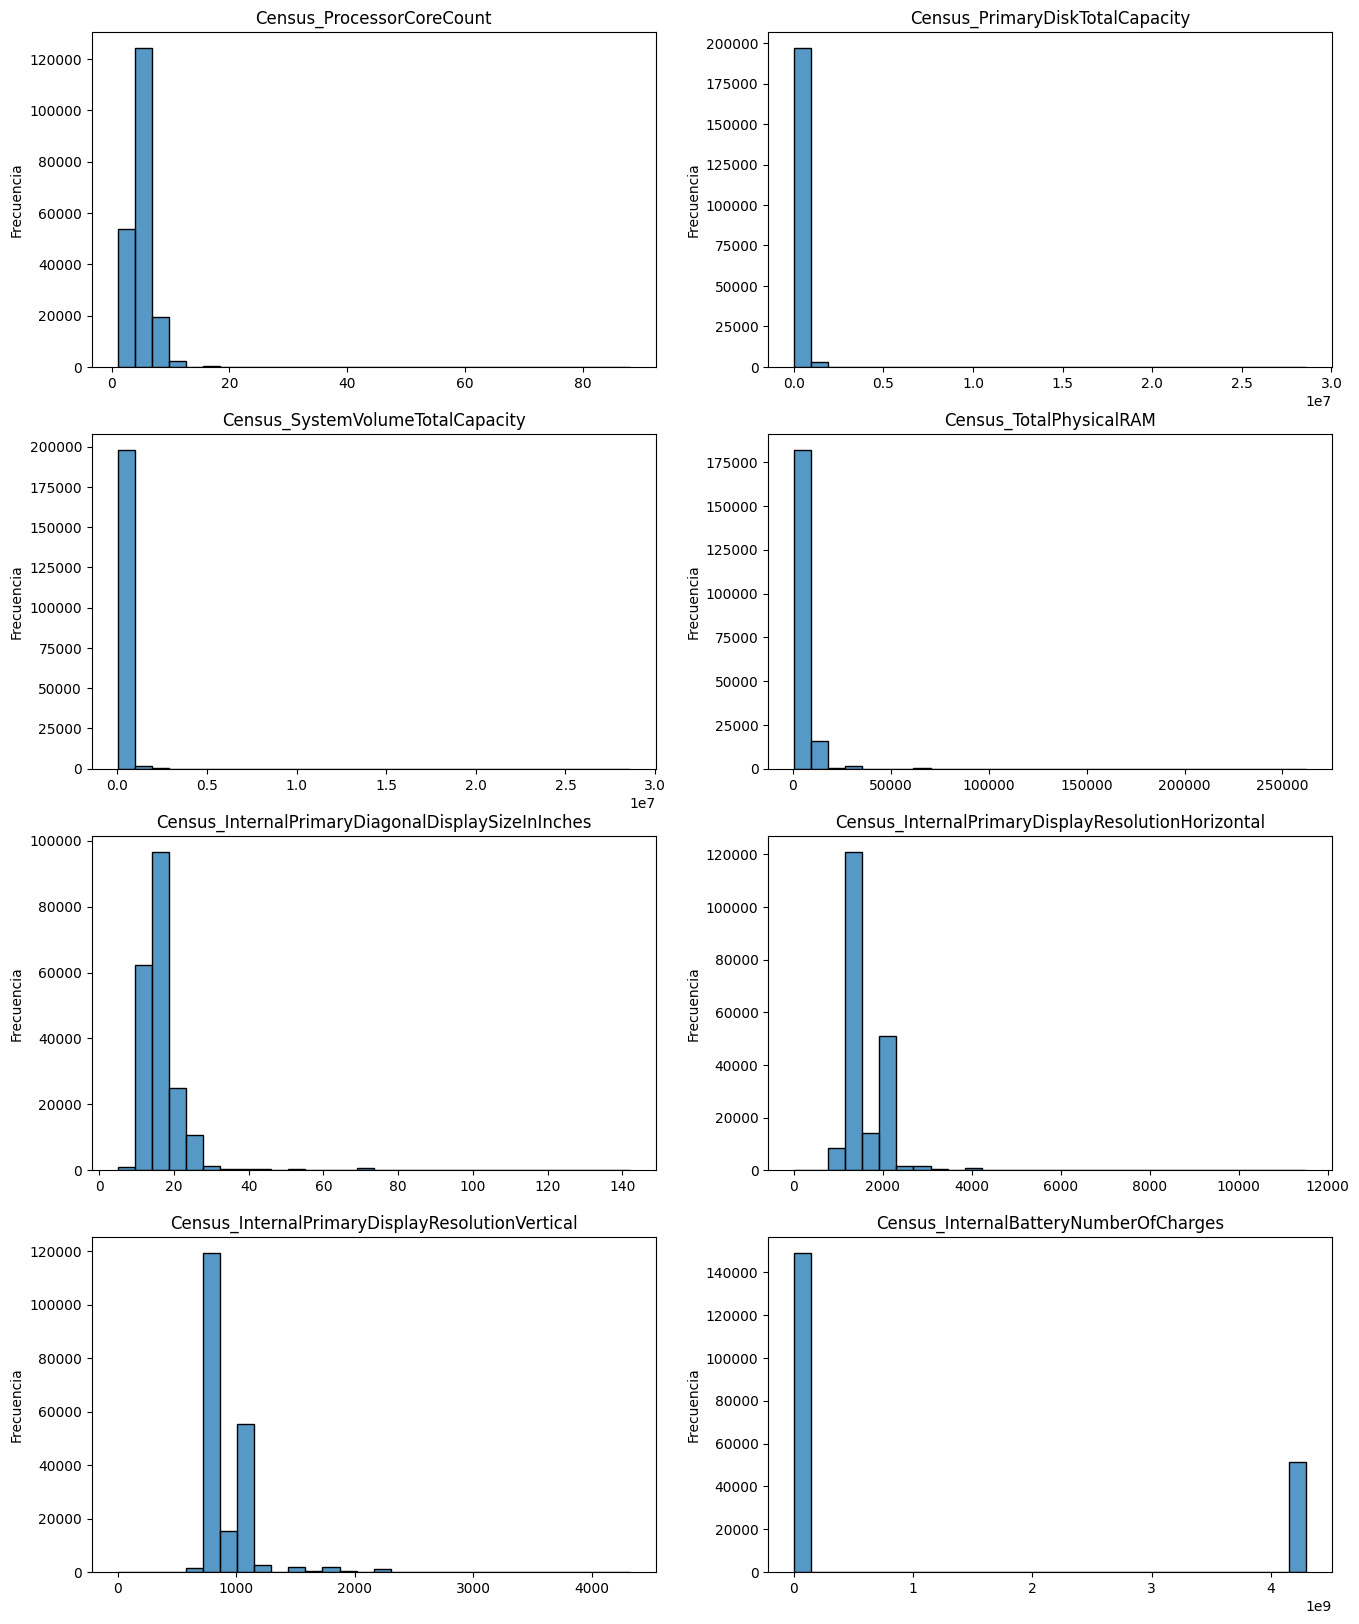

In [46]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
for ax, col in zip(axes.flatten(), lista_var_num):
    sns.histplot(mw_df_reducido[col], bins=30, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')

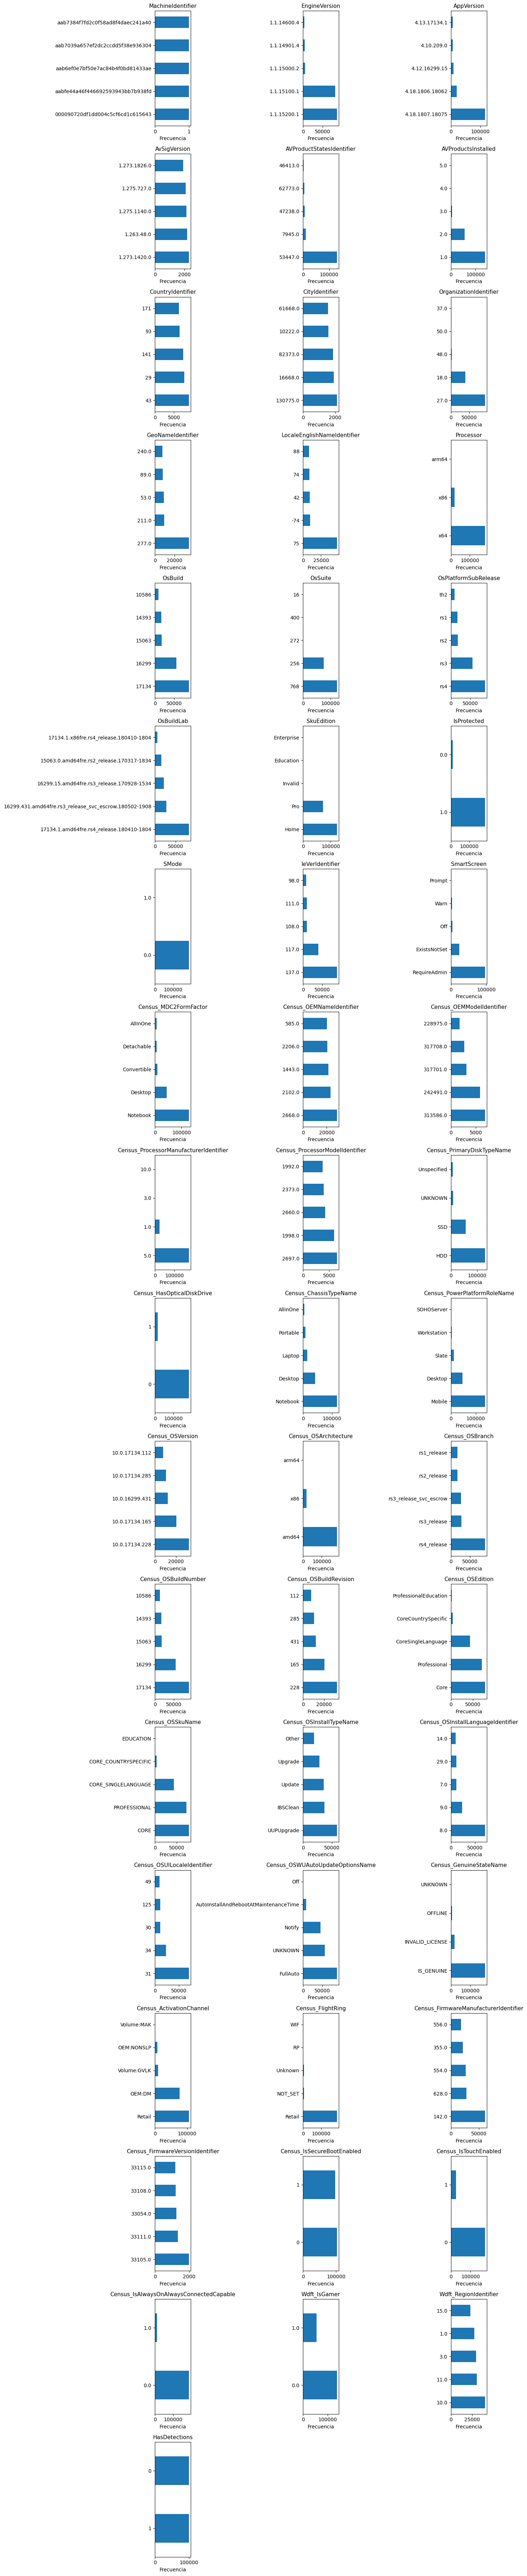

In [47]:
import matplotlib.pyplot as plt

def plot_top_categories(df, col, ax, top_n=10):
    """
    Dibuja un barplot con las top_n categorías de una variable categórica.
    
    df      : DataFrame
    col     : nombre de la columna categórica
    ax      : eje de matplotlib donde dibujar
    top_n   : cuántas categorías mostrar (por defecto 10)
    """
    vc = df[col].value_counts().nlargest(top_n)
    vc.plot(kind='barh', ax=ax)
    ax.set_title(f"{col}", fontsize=11)
    ax.set_xlabel("Frecuencia")
    ax.set_ylabel("")

n_cols = 3  

n_plots = len(lista_var_cat)

n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(lista_var_cat):
    plot_top_categories(mw_df_reducido, col, axes[i], top_n=5)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

En estos gráficos de las variables categóricas se puede observar:

1. Flags binarias muy desbalanceadas

IsProtected, Census_HasOpticalDiskDrive, Census_IsSecureBootEnabled, Census_IsTouchEnabled, Census_IsAlwaysOnAlwaysConnectedCapable y Wdft_IsGamer muestran casi todos los casos en un mismo valor (0 o 1), con la otra categoría casi testimonial (<5 %).

Esto sugiere que, aunque conceptualmente son indicadores útiles, en la práctica aportan muy poca variación.

2. Dos niveles mayoritarios

Processor: casi todos los equipos son x64 y muy pocos x86 (con un puñado de arm64).

OsSuite: predominan los valores 768 y 256 (Home/Pro), mientras que el resto de suites es casi irrelevante.

OsPlatformSubRelease: los lanzamientos rs4 y rs3 agrupan la mayor parte de las instalaciones; los demás sub-releases son muy minoritarios.

3. Diversidad moderada

SkuEdition: “Home” y “Pro” cubren la gran mayoría, con “Enterprise” y “Cloud” muy residual.

Census_PowerPlatformRoleName: se ven claramente Mobile, Desktop y AppliancePC como los tres roles dominantes.

Census_PrimaryDiskTypeName: predomina el HDD, seguido de SSD, y luego niveles como UNKNOWN o Unspecified casi anecdóticos.

4. Variable objetivo equilibrada

HasDetections aparece aproximadamente al 50 % entre 0 y 1, lo que indica que nuestro conjunto de ejemplos “infectados” vs “limpios” está balanceado.

Revisar!!!!!!!!!!!!!La mayoría de estas variables aportan muy poca variación y podrían codificarse directamente, o bien agrupar sus niveles minoritarios en “other” para mayor robustez.


In [48]:
lista_var_binarias = [
    'IsProtected',
    'Census_HasOpticalDiskDrive',
    'Census_IsSecureBootEnabled',
    'Census_IsTouchEnabled',
    'Census_IsAlwaysOnAlwaysConnectedCapable',
    'Wdft_IsGamer'
]

lista_var_cat = [col for col in lista_var_cat if col not in lista_var_binarias]

print("Binarias:", lista_var_binarias)
print("Categóricas restantes:", lista_var_cat)

Binarias: ['IsProtected', 'Census_HasOpticalDiskDrive', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer']
Categóricas restantes: ['MachineIdentifier', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Processor', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'SMode', 'IeVerIdentifier', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OS

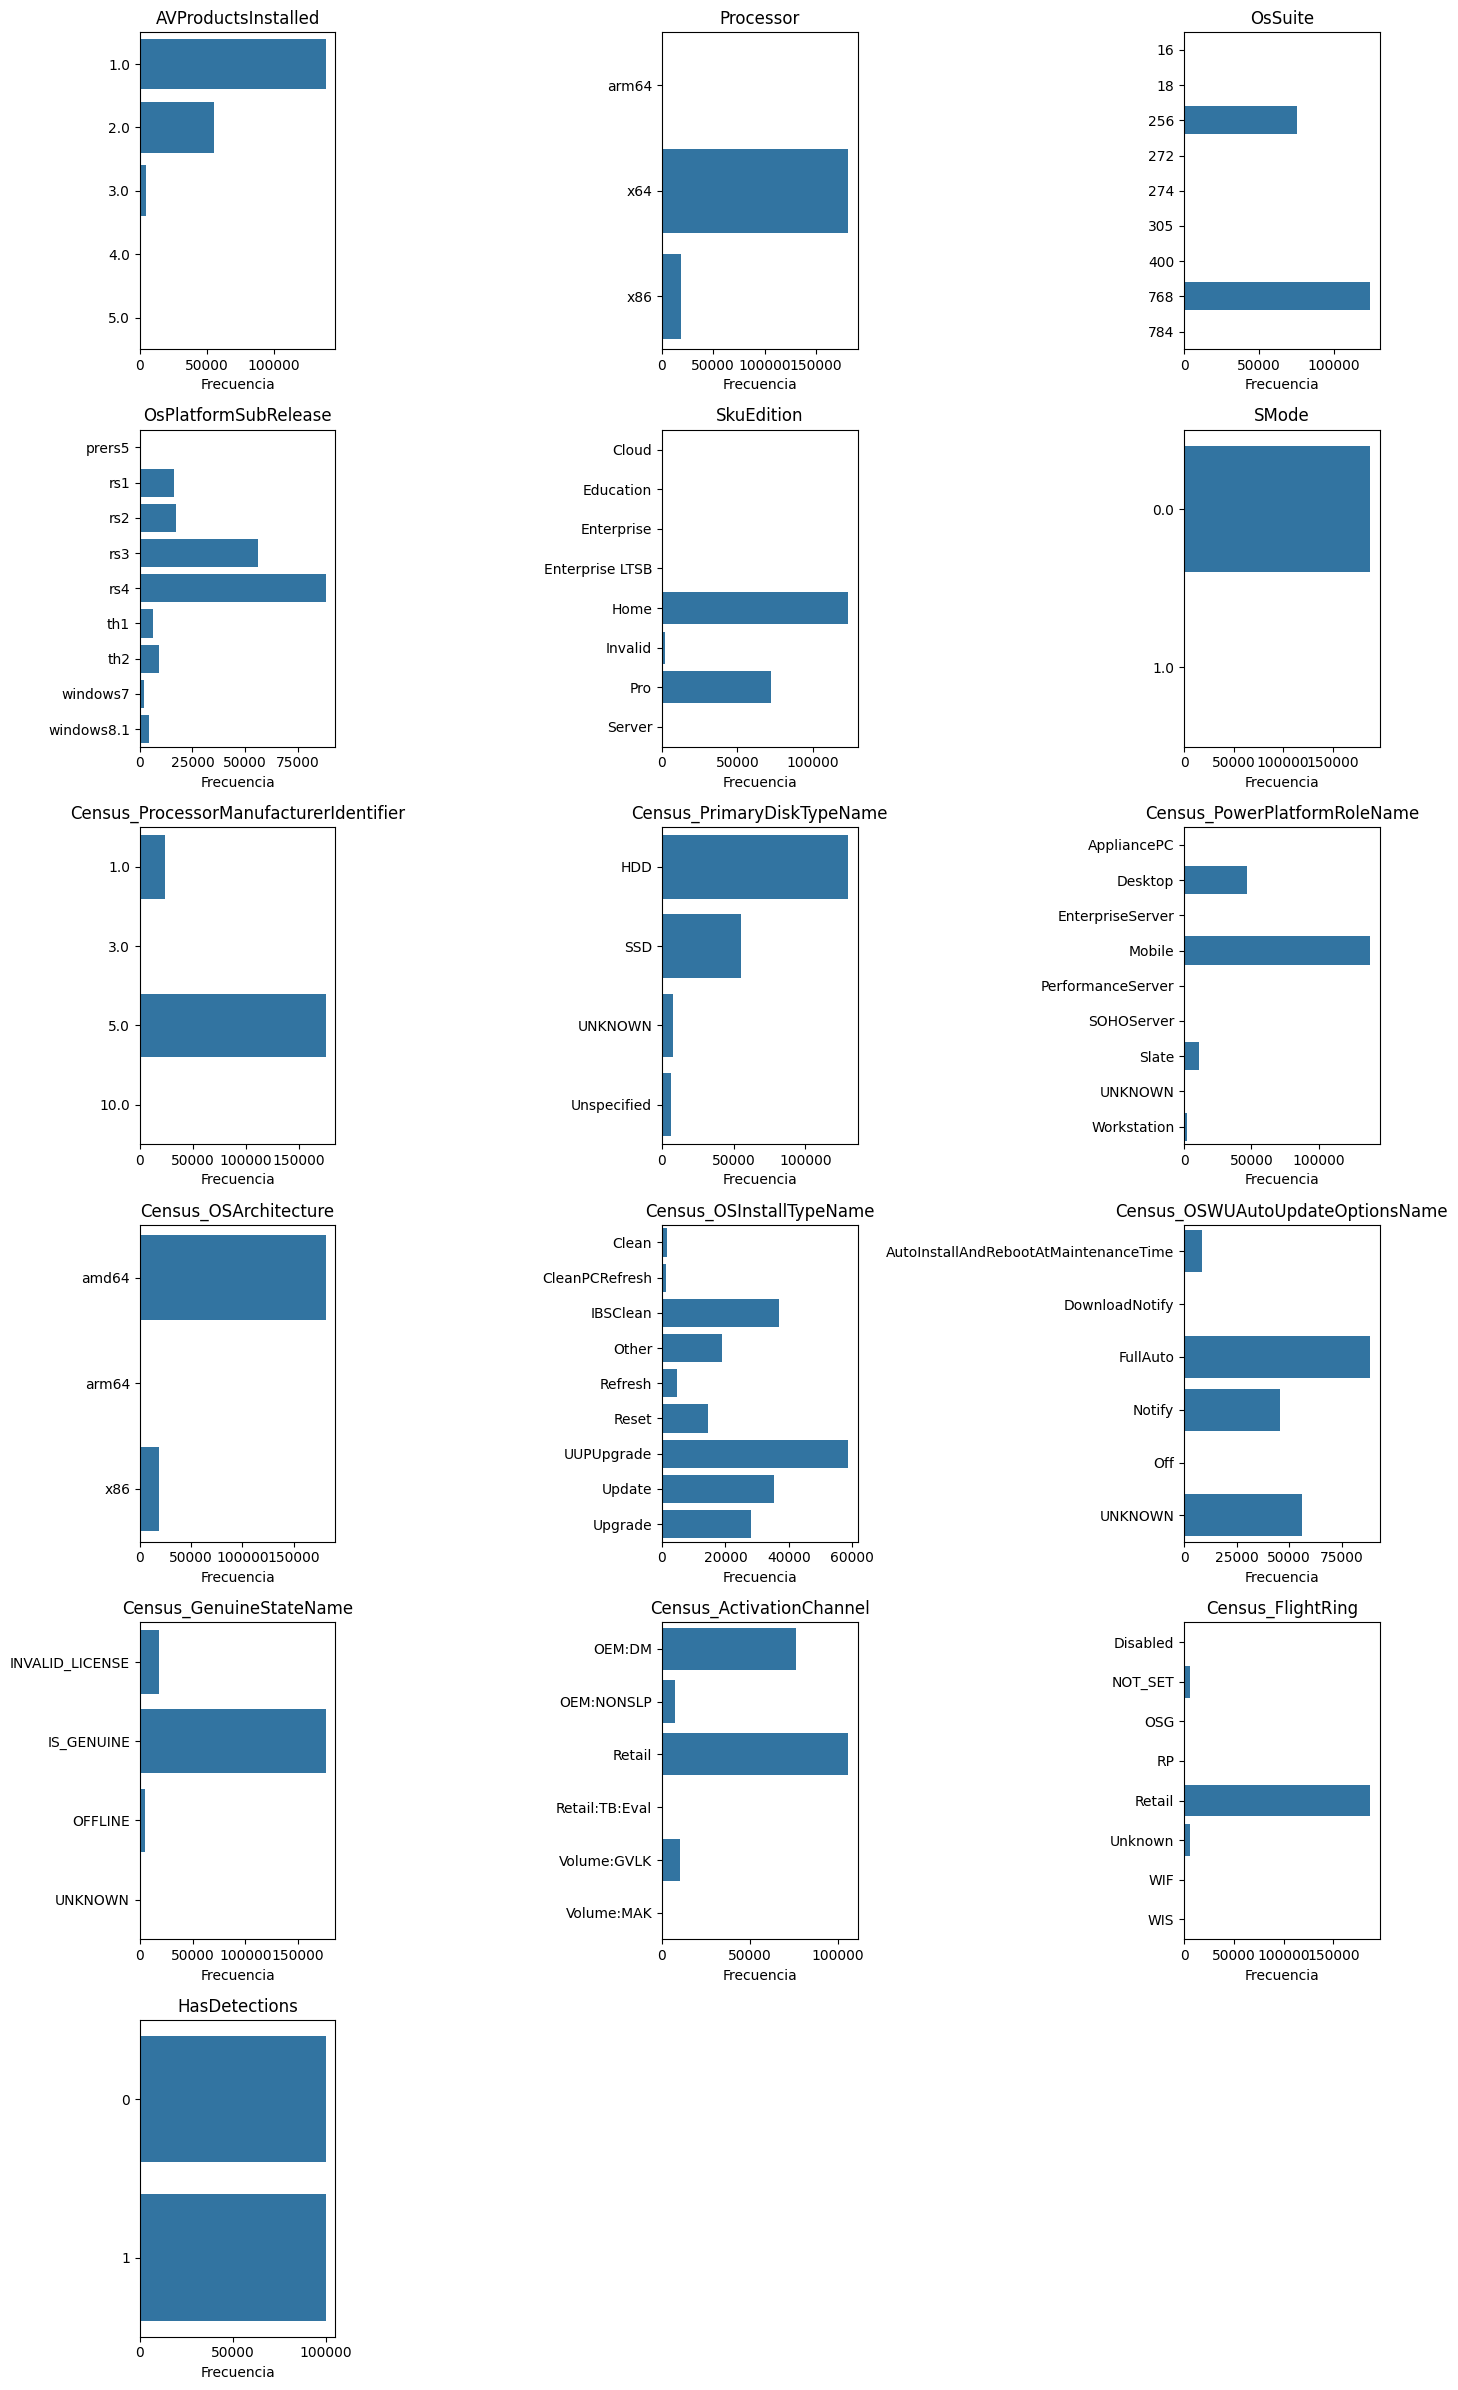

In [49]:
low_card = [c for c in lista_var_cat if mw_df_reducido[c].nunique() <= 10]
n_cols = 3
n_rows = (len(low_card) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for ax, col in zip(axes, low_card):
    vc = mw_df_reducido[col].value_counts()
    sns.barplot(x=vc.values, y=vc.index, ax=ax)
    ax.set_title(f"{col}")
    ax.set_xlabel("Frecuencia")
    ax.set_ylabel("")

for ax in axes[len(low_card):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

La variable SMode esta muy desbalanceada

In [50]:
mw_df_reducido.SMode.value_counts(normalize=True, dropna=False)

SMode
 0.0    0.940525
NaN     0.059040
 1.0    0.000435
Name: proportion, dtype: float64

In [51]:
mw_df_reducido[['SMode'] + [target_variable]].corr()[target_variable].sort_values(ascending=False)

HasDetections    1.000000
SMode           -0.013358
Name: HasDetections, dtype: float64

La variable SMode no aporta valor (varianza casi cero) lo mejor es eliminarla

In [52]:
mw_df_reducido.drop(columns=['SMode'], inplace=True)

In [53]:
lista_var_cat.remove('SMode')

In [54]:
mw_df_reducido.shape

(200000, 59)

# Analisis multivariante: correlación entre variables

In [55]:
corr_target = (mw_df_reducido[lista_var_num].corrwith(mw_df_reducido['HasDetections']).abs().sort_values(ascending=False))
corr_target

Census_TotalPhysicalRAM                              0.060468
Census_ProcessorCoreCount                            0.055099
Census_PrimaryDiskTotalCapacity                      0.048502
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.032696
Census_InternalPrimaryDisplayResolutionHorizontal    0.028998
Census_InternalBatteryNumberOfCharges                0.020092
Census_SystemVolumeTotalCapacity                     0.013977
Census_InternalPrimaryDisplayResolutionVertical      0.011535
dtype: float64

Estos coeficientes son muy bajos (todos < 0.07), lo que indica que ninguna variable continua por sí sola tiene un fuerte efecto lineal sobre el riesgo de detección.

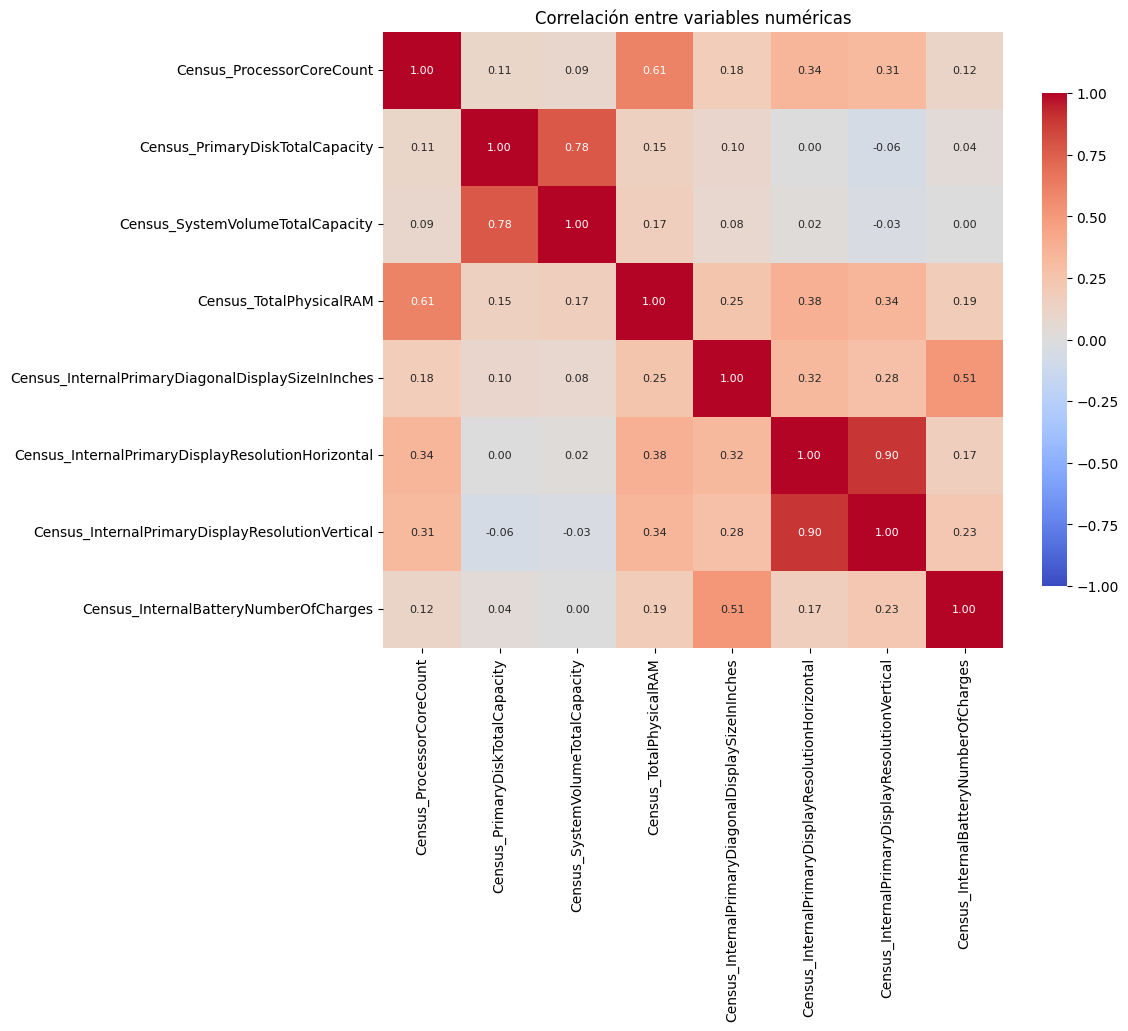

In [56]:
plt.figure(figsize=(10,8))
sns.heatmap(
    mw_df_reducido[lista_var_num].corr(),
    cmap='coolwarm', vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={"size":8},
    cbar_kws={'shrink':.8}
)
plt.title("Correlación entre variables numéricas")
plt.show()

Correlación entre variables numéricas

Census_PrimaryDiskTotalCapacity y Census_SystemVolumeTotalCapacity están muy ligadas (r≈0.78), porque miden tamaños de disco similares.

La resolución horizontal y vertical de pantalla (ResolutionHorizontal vs Vertical) tienen una correlación altísima (r≈0.90), lo cual es lógico: pantallas con más píxeles en X suelen tener más en Y.

Census_TotalPhysicalRAM muestra una correlación moderada con el número de núcleos CPU (r≈0.61), indicando que máquinas con más RAM tienden a tener más cores.

Census_InternalBatteryNumberOfCharges se asocia débilmente con Census_InternalPrimaryDiagonalDisplaySizeInInches (r≈0.51), quizás porque los dispositivos portátiles (pantallas pequeñas) usan baterías recargables.

El resto de pares presentan correlaciones débiles (|r|<0.35), por lo que no evidencian redundancia crítica.

Para evitar multicolinealidad, podríamos optar por eliminar o combinar uno de cada par muy correlacionado

<Axes: xlabel='Census_InternalPrimaryDisplayResolutionHorizontal', ylabel='Census_InternalPrimaryDisplayResolutionVertical'>

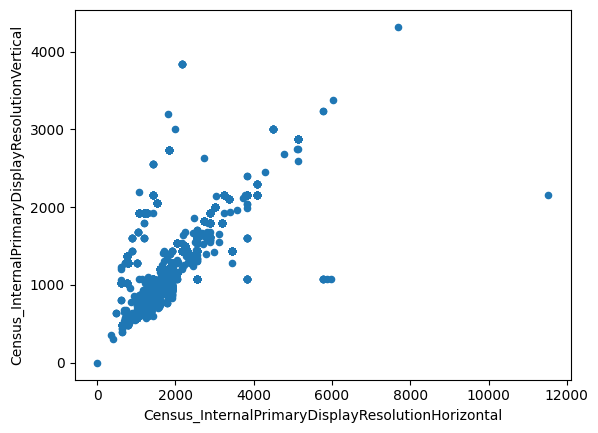

In [57]:
mw_df_reducido.plot(x = 'Census_InternalPrimaryDisplayResolutionHorizontal', y = 'Census_InternalPrimaryDisplayResolutionVertical', kind='scatter')

In [58]:
corr_target = (mw_df_reducido[lista_var_binarias].corrwith(mw_df_reducido['HasDetections']).abs().sort_values(ascending=False))
corr_target

Census_IsAlwaysOnAlwaysConnectedCapable    0.064249
Wdft_IsGamer                               0.059519
IsProtected                                0.053792
Census_IsTouchEnabled                      0.041240
Census_HasOpticalDiskDrive                 0.023525
Census_IsSecureBootEnabled                 0.002060
dtype: float64

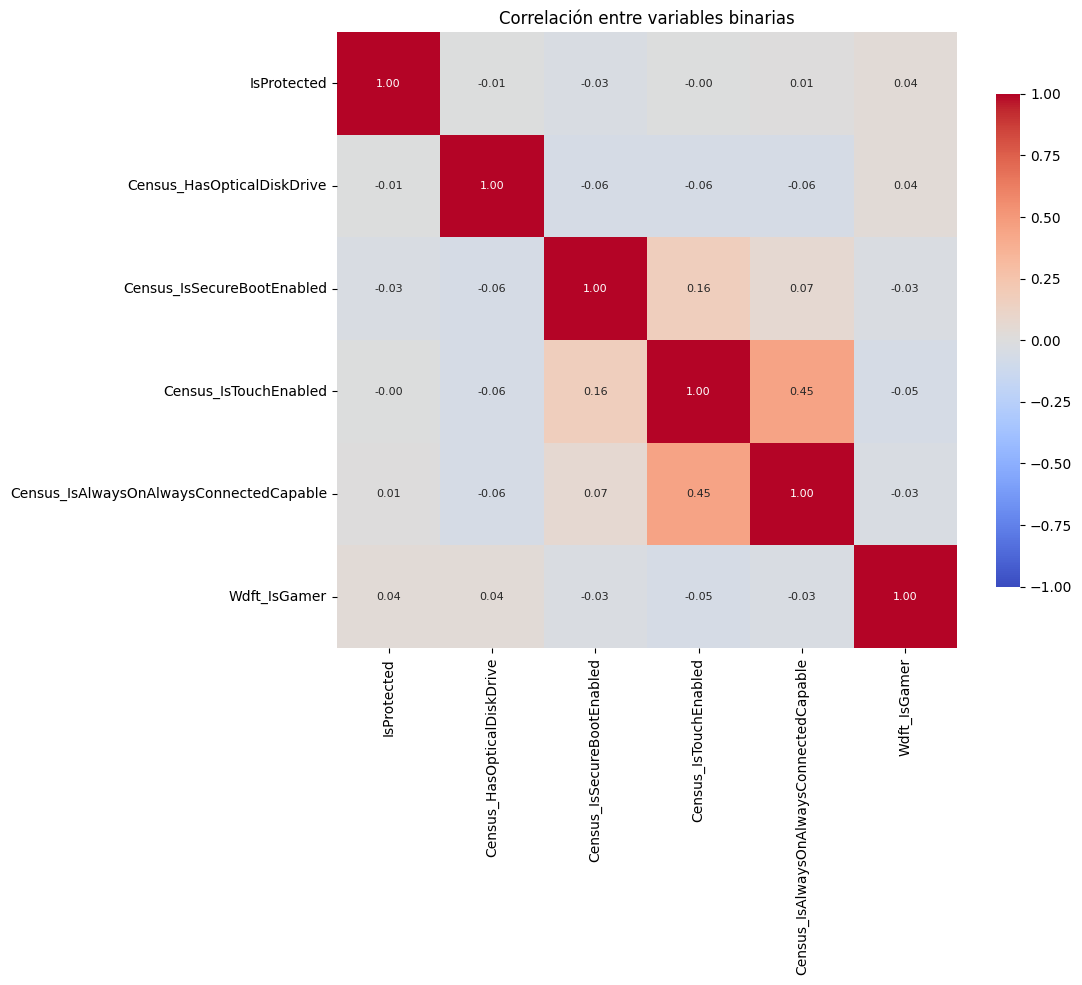

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(
    mw_df_reducido[lista_var_binarias].corr(),
    cmap='coolwarm', vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={"size":8},
    cbar_kws={'shrink':.8}
)
plt.title("Correlación entre variables binarias")
plt.show()

In [60]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm, correction=False)[0]
    n = cm.values.sum()
    phi2 = chi2 / n
    r, k = cm.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

low_card_existing = [col for col in low_card if col in mw_df_reducido.columns]

cramers = {col: cramers_v(mw_df_reducido[col], mw_df_reducido['HasDetections'])for col in low_card_existing}

cramers_s = pd.Series(cramers).sort_values(ascending=False)

print("Cramér’s V (categóricas bajas vs HasDetections):")
print(cramers_s)


Cramér’s V (categóricas bajas vs HasDetections):
HasDetections                             1.000000
AVProductsInstalled                       0.147552
Census_PowerPlatformRoleName              0.068990
Processor                                 0.068582
Census_OSArchitecture                     0.067819
Census_OSInstallTypeName                  0.047376
Census_ActivationChannel                  0.045582
OsPlatformSubRelease                      0.040432
Census_OSWUAutoUpdateOptionsName          0.035417
Census_PrimaryDiskTypeName                0.028165
SkuEdition                                0.024354
OsSuite                                   0.023945
Census_GenuineStateName                   0.017670
Census_FlightRing                         0.014197
Census_ProcessorManufacturerIdentifier    0.010052
dtype: float64


AVProductsInstalled (V≈0.15) es la que más asociación muestra.

A continuación, Census_PowerPlatformRoleName, Processor y Census_OSArchitecture quedan en torno a V≈0.06–0.07.

El resto de variables cae por debajo de V≈0.05, lo que sugiere prácticamente ausencia de señal lineal con el riesgo de detección.

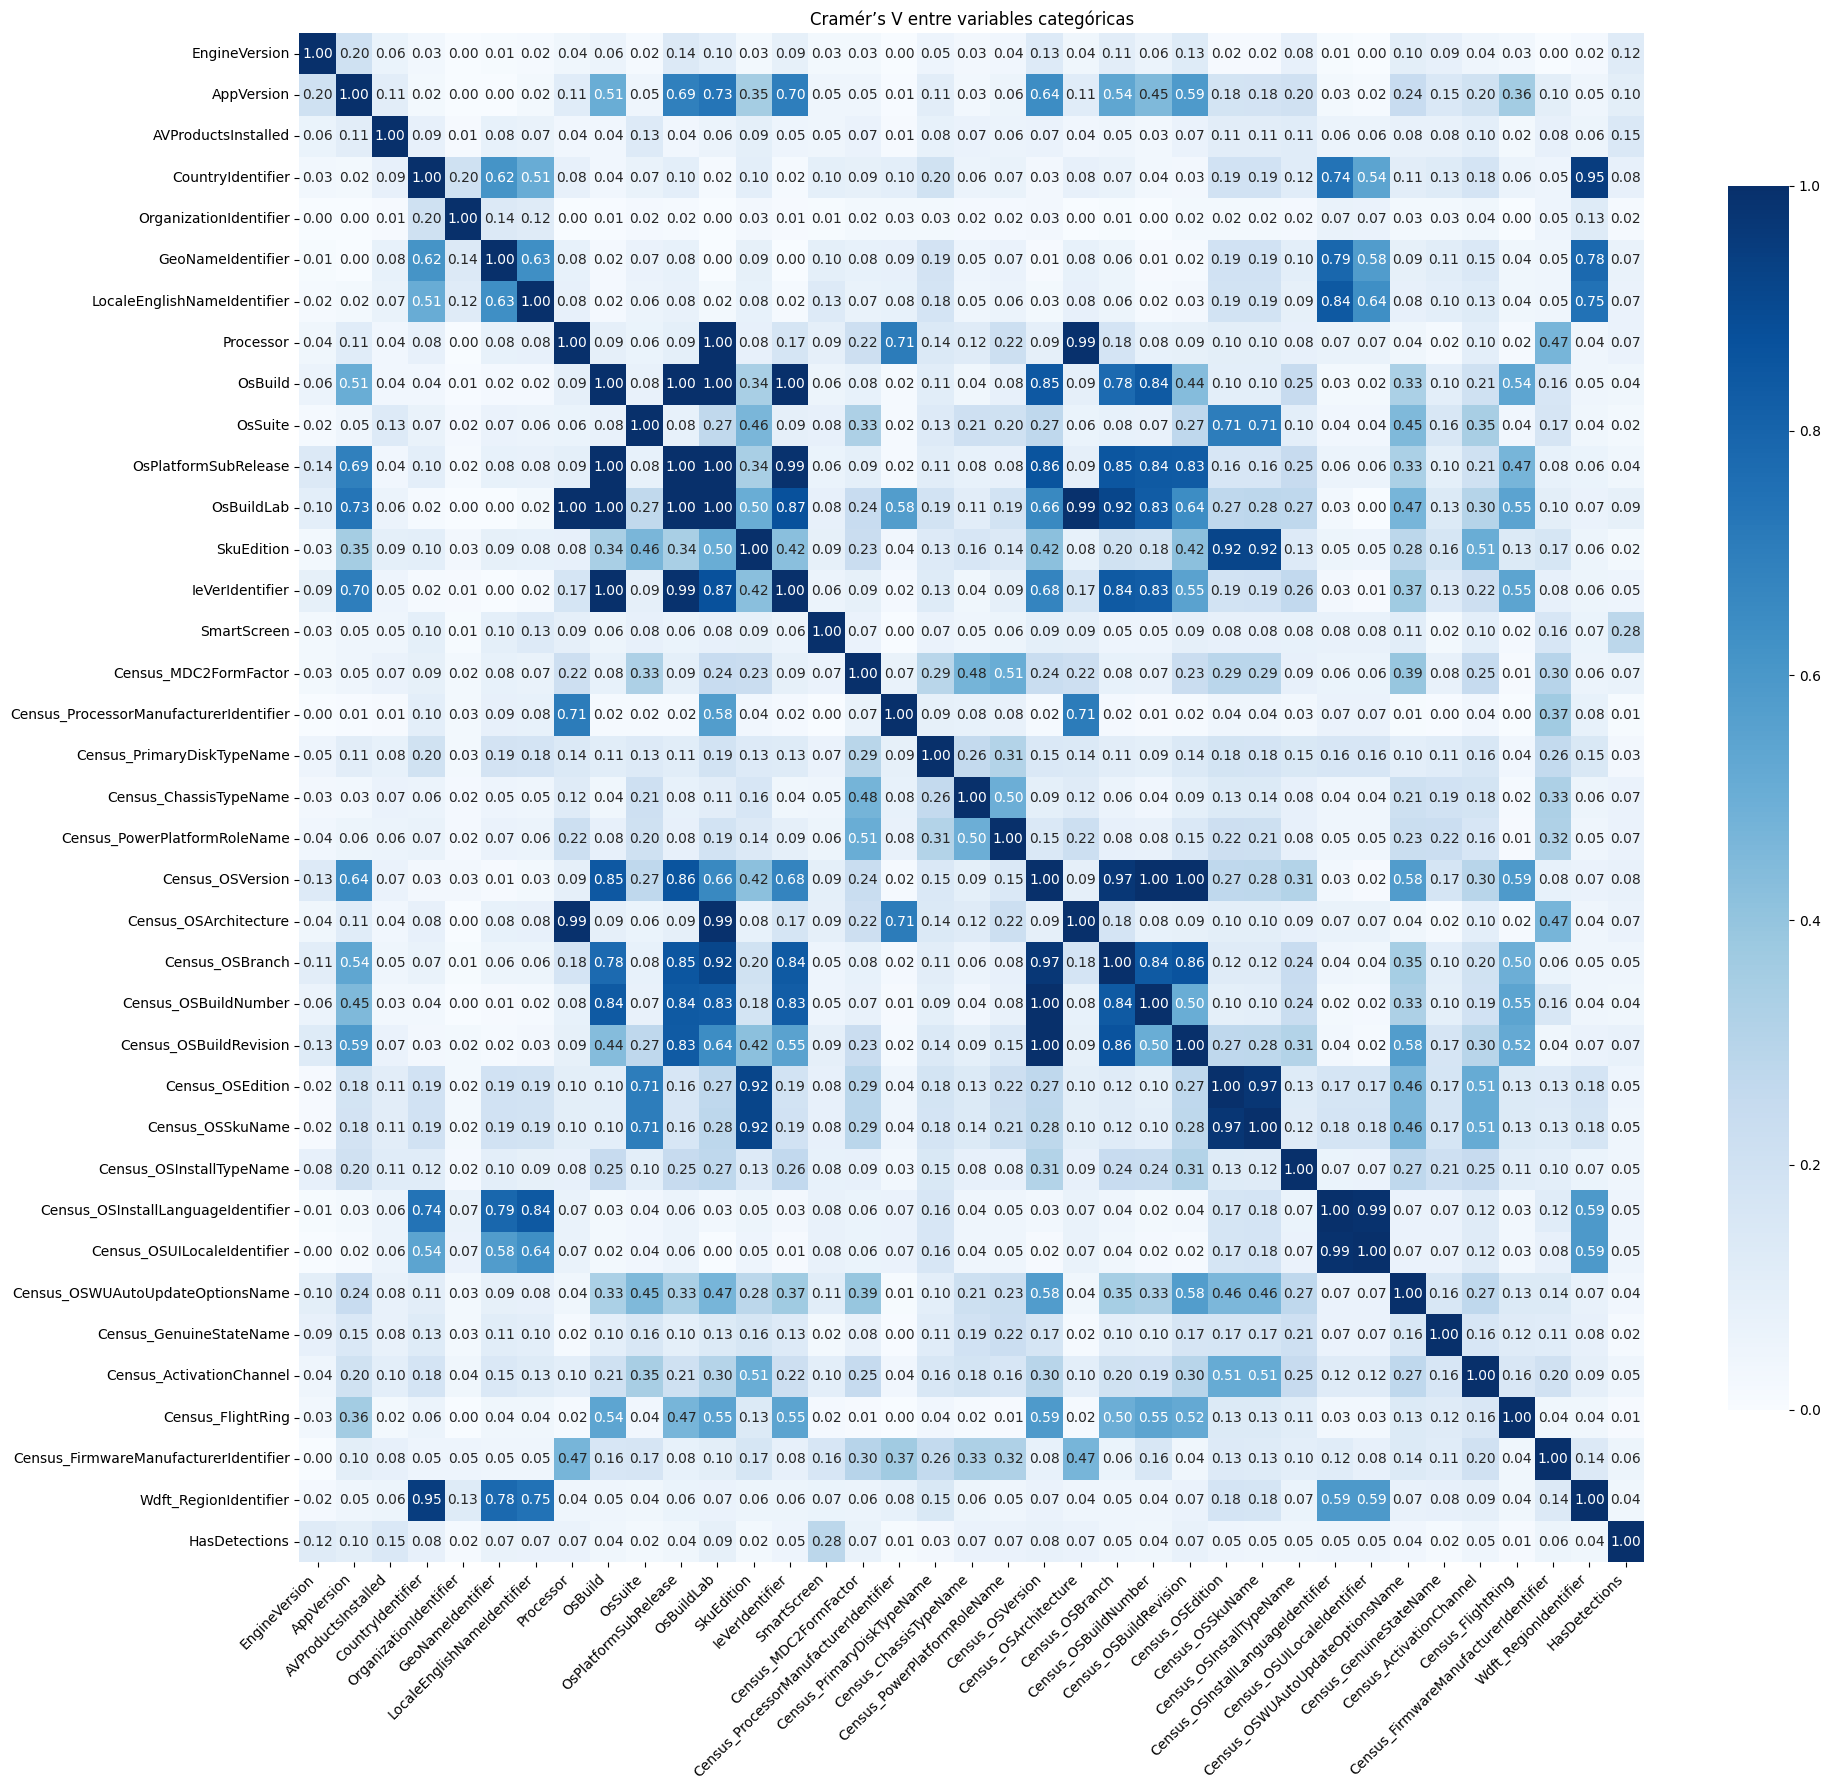

In [61]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm, correction=False)[0]
    n = cm.values.sum()
    phi2 = chi2 / n
    r, k = cm.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))

max_levels = 500
cat_existing = [
    col for col in lista_var_cat
    if col in mw_df_reducido and mw_df_reducido[col].nunique() <= max_levels
]

cramer_matrix = pd.DataFrame(
    index=cat_existing, columns=cat_existing, dtype=float
)
for c1 in cat_existing:
    for c2 in cat_existing:
        if c1 == c2:
            cramer_matrix.loc[c1, c2] = 1.0
        else:
            cramer_matrix.loc[c1, c2] = cramers_v(
                mw_df_reducido[c1], mw_df_reducido[c2]
            )

plt.figure(figsize=(20,18))
sns.heatmap(
    cramer_matrix,
    annot=True, fmt=".2f", cmap="Blues",
    cbar_kws={'shrink': .8}
)
plt.title("Cramér’s V entre variables categóricas")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Análisis de redundancia entre categóricas
El heatmap de Cramér’s V nos muestra varios grupos de variables que capturan la misma información. Por ejemplo, las diferentes formas de indicar la versión de Windows (OsBuild, OsBuildLab, Census_OSBuildNumber, Census_OSBuildRevision) están perfectamente correlacionadas (V≈1.0).
Para optimizar nuestro modelo, elimino estas variables redundantes. 

De este modo reducimos la multicolinealidad, aligeramos el dataset y mantenemos solo las features que aportan valor.

In [62]:
mat = cramer_matrix.copy()

mask = np.triu(np.ones(mat.shape), k=1).astype(bool)
pairs = (
    mat.where(mask)
       .stack()
       .reset_index()
       .rename(columns={'level_0':'var1','level_1':'var2',0:'V'})
       .sort_values('V', ascending=False)
)

redundant = pairs[pairs['V'] > 0.98]
print("Pares muy correlacionados (V>0.98):\n", redundant)

Pares muy correlacionados (V>0.98):
                                    var1                         var2         V
261                             OsBuild         OsPlatformSubRelease  0.999920
533                    Census_OSVersion       Census_OSBuildRevision  0.999886
532                    Census_OSVersion         Census_OSBuildNumber  0.999417
262                             OsBuild                   OsBuildLab  0.999097
315                OsPlatformSubRelease                   OsBuildLab  0.999017
234                           Processor                   OsBuildLab  0.999002
264                             OsBuild              IeVerIdentifier  0.996452
244                           Processor        Census_OSArchitecture  0.994250
350                          OsBuildLab        Census_OSArchitecture  0.993972
317                OsPlatformSubRelease              IeVerIdentifier  0.991159
630  Census_OSInstallLanguageIdentifier  Census_OSUILocaleIdentifier  0.989718


Tras calcular Cramér’s V entre todas las variables categóricas, encontramos varios bloques con V>0.98, lo que implica que capturan exactamente la misma información.
Para aligerar el modelo y evitar multicolinealidad, mantenemos un solo miembro de cada grupo semántico (por ejemplo, sólo Census_OSVersion en lugar de todos los campos de build). 

In [63]:
to_drop = [
    'Census_OSBuildNumber',
    'Census_OSBuildRevision',
    'OsPlatformSubRelease',
    'OsBuild',
    'OsBuildLab',
    'IeVerIdentifier',
    'Census_OSArchitecture',
    'Census_OSUILocaleIdentifier'
]

mw_df_reducido.drop(columns=to_drop, inplace=True)

print("Quedan estas categóricas tras el drop:", 
      mw_df_reducido.select_dtypes(include=['category','object']).columns.tolist())

Quedan estas categóricas tras el drop: ['MachineIdentifier', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Processor', 'OsSuite', 'SkuEdition', 'IsProtected', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled', 'Census_IsTouc

Tras identificar con Cramér’s V clusters de variables prácticamente idénticas (V>0.98), he optado por conservar sólo un “representante” de cada grupo semántico.

In [64]:
lista_var_cat = mw_df_reducido.select_dtypes(include=['category','object']).columns.tolist()

In [65]:
mw_df_reducido.shape

(200000, 51)

In [66]:
mw_df_reducido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 51 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   MachineIdentifier                                  200000 non-null  category
 1   EngineVersion                                      200000 non-null  category
 2   AppVersion                                         200000 non-null  category
 3   AvSigVersion                                       200000 non-null  category
 4   AVProductStatesIdentifier                          199238 non-null  category
 5   AVProductsInstalled                                199238 non-null  category
 6   CountryIdentifier                                  200000 non-null  category
 7   CityIdentifier                                     192702 non-null  category
 8   OrganizationIdentifier                             138255 non-nu

Tras revisar la estructura final del DataFrame con .info(), vemos que tenemos 51 columnas:

43 categóricas, incluyendo todavía algunos NaN en variables como AVProductStatesIdentifier, SmartScreen, OrganizationIdentifier o Wdft_RegionIdentifier.

8 numéricas en float32.

El uso de memoria es muy eficiente (24.5 MB para 200 000 filas).

Reducir cardinalidad de las versiones  
Las columnas `EngineVersion`, `AppVersion` y `AvSigVersion` contienen cadenas con varias partes que generan cientos de niveles únicos. Para agruparlas en familias de versión y facilitar la codificación, extraemos solo los dos primeros segmentos.

In [67]:
for col in ['EngineVersion', 'AppVersion', 'AvSigVersion']: mw_df_reducido[col] = (mw_df_reducido[col].astype(str).str.split('.', n=2).str[:2].str.join('.').astype('category'))


Comprobación de valores faltantes en todo el DataFrame 


1. Calculamos el **número** y el **porcentaje** de valores faltantes en cada columna.  
2. Filtramos para mostrar sólo aquellas que tienen al menos un `NaN`.  

De esta forma nos aseguramos de no pasar por alto ningún dato faltante.  

In [68]:
nulos     = mw_df_reducido.isnull().sum()
pct_nulos = (mw_df_reducido.isnull().mean() * 100).round(2)
nulls_df  = pd.DataFrame({'nulos': nulos, '% nulos': pct_nulos})

print("Columnas con valores faltantes:")
print(nulls_df[nulls_df['nulos'] > 0])

Columnas con valores faltantes:
                                         nulos  % nulos
AVProductStatesIdentifier                  762     0.38
AVProductsInstalled                        762     0.38
CityIdentifier                            7298     3.65
OrganizationIdentifier                   61745    30.87
GeoNameIdentifier                            6     0.00
IsProtected                                756     0.38
SmartScreen                              71459    35.73
Census_OEMNameIdentifier                  2131     1.07
Census_OEMModelIdentifier                 2281     1.14
Census_ProcessorManufacturerIdentifier     935     0.47
Census_ProcessorModelIdentifier            935     0.47
Census_PrimaryDiskTypeName                 298     0.15
Census_ChassisTypeName                      11     0.01
Census_OSInstallLanguageIdentifier        1340     0.67
Census_FirmwareManufacturerIdentifier     4061     2.03
Census_FirmwareVersionIdentifier          3554     1.78
Census_IsAlwaysO

**Imputación diferenciada según proporción de faltantes**  
No todas las columnas con valores ausentes requieren el mismo tratamiento. Dependiendo de cuánto `NaN` tenga cada variable categórica, podemos elegir:

1. **Bajo porcentaje de missing (< 5 %)**  
   - Usar la **moda** (valor más frecuente) para rellenar: evitamos crear un nivel “missing” que apenas aparecerá y preservamos la distribución original.  

2. **Alto porcentaje de missing (≥ 5 %)**  
   - Introducir un nivel explícito `"missing"`: el que falte información a menudo es en sí mismo una señal (p.ej. no se reportó SmartScreen).  

Este enfoque mantiene la mayor parte de la señal real y no infla el número de categorías con niveles casi vacíos.

In [69]:
imputed_with_missing = []

for col in lista_var_cat:
    pct = mw_df_reducido[col].isna().mean()
    
    if pct < 0.05:
        mode = mw_df_reducido[col].mode()[0]
        mw_df_reducido[col] = mw_df_reducido[col].fillna(mode)
    else:
        mw_df_reducido[col] = (
            mw_df_reducido[col]
            .cat.add_categories('missing')
            .fillna('missing')
        )
        imputed_with_missing.append(col)
print("Imputadas con 'missing':", imputed_with_missing)


Imputadas con 'missing': ['OrganizationIdentifier', 'SmartScreen']


**Verificación final de valores faltantes**  
Antes de proceder al modelado, comprobamos que no queda ningún `NaN` en el DataFrame:

1. Calculamos el conteo de `NaN` en cada columna.  
2. Si todo está en 0, confirmamos que el dataset está limpio y listo para la fase de modelado.  

In [70]:
nulos     = mw_df_reducido.isnull().sum()
pct_nulos = (mw_df_reducido.isnull().mean() * 100).round(2)
nulls_df  = pd.DataFrame({'nulos': nulos, '% nulos': pct_nulos})

print("Columnas con valores faltantes:")
print(nulls_df[nulls_df['nulos'] > 0])

Columnas con valores faltantes:
Empty DataFrame
Columns: [nulos, % nulos]
Index: []


# Modelos

Elegimos XGBoost porque, combinado con este pipeline que escala numéricas y codifica categóricas de forma eficiente (sparse/ordinal), ofrece un baseline sólido y rápido sin explotar la memoria. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

X = mw_df_reducido.drop('HasDetections', axis=1)
y = mw_df_reducido['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

num_cols = X_train.select_dtypes(include=['int8','int16','int32','float32','float64']) \
                   .columns.tolist()
cat_cols = [
    c for c in X_train.select_dtypes(include=['category','object']).columns
    if c != 'MachineIdentifier'
]

low_card  = [c for c in cat_cols if X_train[c].nunique() <= 10]
high_card = [c for c in cat_cols if X_train[c].nunique() >  10]

for c in cat_cols:
    if X_train[c].isna().any():
        X_train[c] = X_train[c].fillna('missing')
        X_test[c]  = X_test[c].fillna('missing')
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

numeric_pipe = Pipeline([
    ('scaler', StandardScaler())
])
low_card_pipe = Pipeline([
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=True
    ))
])
high_card_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',     numeric_pipe,   num_cols),
        ('lowcat',  low_card_pipe,  low_card),
        ('highcat', high_card_pipe, high_card),
    ],
    sparse_threshold=0 
)

clf = Pipeline([
    ('preproc', preprocessor),
    ('model',   XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

clf.fit(X_train, y_train)

print("Train Accuracy:", clf.score(X_train, y_train))
print("Test  Accuracy:", clf.score(X_test,  y_test))


Train Accuracy: 0.69639375
Test  Accuracy: 0.64135


El que el modelo alcance un ~70 % de acierto en train y baje al ~64 % en test nos dice:

Se está quedando corto para capturar toda la señal: ni en entrenamiento llega a un accuracy alto, así que su capacidad de aprendizaje es limitada con las features actuales.

La caída al test (-6 p.p.) indica algo de over-fitting leve, pero el problema principal es el under-fitting, es decir, que las transformaciones y el modelo base no están extrayendo suficiente información.

Usamos Regresión Logística con L2 como baseline porque es muy rápida de entrenar, funciona bien con datos numéricos y categóricos y nos dice si hay señal lineal en las features.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf',    LogisticRegression(
                   penalty='l2',
                   C=1.0,
                   max_iter=1000,
                   random_state=42,
                   n_jobs=-1
               ))
])

lr_pipe.fit(X_train, y_train)
print("LR train Acc:", lr_pipe.score(X_train, y_train))
print("LR  test Acc:", lr_pipe.score(X_test,  y_test))


LR train Acc: 0.56329375
LR  test Acc: 0.55945


Al estar casi clavado train vs. test, no hay over-fitting, pero el accuracy es bajo: indica que las relaciones no son puramente lineales y el modelo lineal se queda corto.

Usamos RandomForest porque maneja bien interacciones no lineales.

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)
print("RF train Acc:", rf_pipe.score(X_train, y_train))
print("RF test  Acc:", rf_pipe.score(X_test,  y_test))

RF train Acc: 0.9999625
RF test  Acc: 0.63375


El modelo memoriza el conjunto de entrenamiento (over-fitting).

El test no mejora frente al baseline (~64% con XGBoost), así que necesitamos restringir la profundidad o ajustar otros hiper-parámetros para reducir el over-fitting.

Para no fiarnos de un único split (train/test) y tener una métrica más estable, aplicamos una validación cruzada estratificada (5 folds). Esto:

Divide X_train/y_train en 5 partes manteniendo el % de HasDetections en cada uno.

En cada fold entrena en 4/5 y evalúa en 1/5.

Calcula la ROC AUC en cada partición con cross_val_score(..., scoring='roc_auc').

In [77]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(
    clf, 
    X_train, y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC CV scores:", np.round(auc_scores, 4))
print("Mean AUC:", np.round(auc_scores.mean(), 4), 
      "±", np.round(auc_scores.std(), 4))

ROC AUC CV scores: [0.7002 0.6952 0.6966 0.6989 0.6977]
Mean AUC: 0.6977 ± 0.0017


El modelo obtiene un AUC≈0.698 de media, con una desviación muy pequeña (±0.0017), lo que confirma que su rendimiento es consistente y no depende de un split particular.

La búsqueda de hiperparámetros
Queremos optimizar nuestra versión de XGBoost para maximizar el ROC AUC y no quedarse en las configuraciones por defecto. Para ello usamos `RandomizedSearchCV` con validación cruzada estratificada a 5 folds, probando 20 combinaciones aleatorias de `n_estimators`, `max_depth`, `learning_rate` y `colsample_bytree`. Esto nos permite encontrar rápidamente un buen compromiso entre sesgo y varianza.


In [80]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split

X = mw_df_reducido.drop('HasDetections', axis=1)
y = mw_df_reducido['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

num_cols = X_train.select_dtypes(include=['int8','int16','int32','float32','float64']).columns.tolist()
cat_cols = [c for c in X_train.select_dtypes(include=['category','object']).columns if c != 'MachineIdentifier']

low_card  = [c for c in cat_cols if X_train[c].nunique() <= 10]
high_card = [c for c in cat_cols if X_train[c].nunique() > 10]

for c in cat_cols:
    if X_train[c].isna().any():
        X_train[c] = X_train[c].fillna('missing')
        X_test[c]  = X_test[c].fillna('missing')
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

numeric_pipe = Pipeline([('scaler', StandardScaler())])
low_card_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
high_card_pipe = Pipeline([('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',     numeric_pipe,   num_cols),
        ('lowcat',  low_card_pipe,  low_card),
        ('highcat', high_card_pipe, high_card),
    ],
    sparse_threshold=0
)

clf = Pipeline([
    ('preproc', preprocessor),
    ('model',   XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_dist = {
    'model__n_estimators':     [100, 300, 500, 800],
    'model__max_depth':        [3, 5, 7, 10],
    'model__learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'model__colsample_bytree': [0.5, 0.7, 1.0]
}
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)

print("Mejores params:", search.best_params_)
print("Mejor CV AUC:", round(search.best_score_, 4))

best_clf = search.best_estimator_

train_auc = best_clf.score(X_train, y_train)
test_auc  = best_clf.score(X_test,  y_test)

print("Train AUC:", round(train_auc, 4))
print("Test  AUC:", round(test_auc,  4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores params: {'model__n_estimators': 800, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.5}
Mejor CV AUC: 0.7075
Train AUC: 0.7416
Test  AUC: 0.6478


 **Mejores parámetros**:  
  - `n_estimators=800`, `max_depth=10`, `learning_rate=0.01`, `colsample_bytree=0.5`.  
- **ROC AUC medio en CV**: 0.7075 → sugiere un salto de ~0.01–0.02 puntos respecto al baseline.  
- **Train AUC**: 0.7416 (buena capacidad de fit, algo de over-fitting con respecto a CV).  
- **Test AUC**: 0.6478 (mejora ligera sobre ~0.64 anterior, pero margen para seguir puliendo).

**Interpretación**  
1. El aumento de CV AUC a 0.7075 confirma que estos hiperparámetros capturan mejor la señal.  
2. La diferencia entre Train (0.7416) y Test (0.6478) muestra cierto sobre-ajuste; convendría restringir un poco la profundidad o regularizar más.  

In [82]:
from lightgbm import LGBMClassifier

lgb_pipe = Pipeline([
    ('preproc', preprocessor),
    ('model',   LGBMClassifier(random_state=42, verbosity=-1))
])

param_dist_lgb = {
    'model__n_estimators':     [100, 300, 500, 800],
    'model__num_leaves':       [31, 50, 80, 120],
    'model__max_depth':        [ 5, 10, 15, -1],
    'model__learning_rate':    [0.01, 0.05, 0.1],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_lgb = RandomizedSearchCV(
    estimator        = lgb_pipe,
    param_distributions = param_dist_lgb,
    n_iter           = 20,
    scoring          = 'roc_auc',
    cv               = cv,
    random_state     = 42,
    n_jobs           = -1,
    verbose          = 1
)

search_lgb.fit(X_train, y_train)

print("LightGBM best params:", search_lgb.best_params_)
print("LightGBM best CV AUC:", round(search_lgb.best_score_, 4))

best_lgb = search_lgb.best_estimator_
train_auc = best_lgb.score(X_train, y_train)
test_auc  = best_lgb.score(X_test,  y_test)
print("LightGBM Train AUC:", round(train_auc, 4))
print("LightGBM Test  AUC:", round(test_auc,  4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
LightGBM best params: {'model__num_leaves': 80, 'model__n_estimators': 300, 'model__max_depth': -1, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6}
LightGBM best CV AUC: 0.7067
LightGBM Train AUC: 0.7023
LightGBM Test  AUC: 0.6465


Tras comparar XGBoost y LightGBM con búsquedas de hiperparámetros estratificadas, XGBoost obtuvo un CV AUC ligeramente superior (0.7075 vs. 0.7067) y un Test AUC más alto (0.6478 vs. 0.6465). Por tanto, elegimos XGBoost como modelo definitivo.

# Modelo final

In [95]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve
)

Queremos cuantificar, de forma más intuitiva que con un simple accuracy, cuántos positivos y negativos reales detecta bien nuestro modelo y en qué proporción comete cada tipo de error (falsos positivos vs falsos negativos)

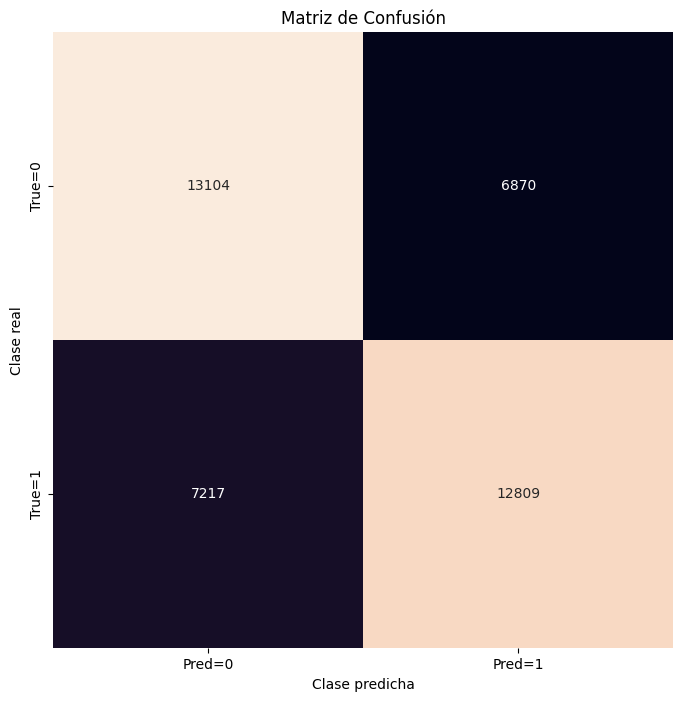

In [96]:
y_pred     = best_clf.predict(X_test)
y_proba    = best_clf.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Pred=0','Pred=1'],
            yticklabels=['True=0','True=1'])
plt.title("Matriz de Confusión")
plt.ylabel("Clase real")
plt.xlabel("Clase predicha")
plt.show()

TN=13 104, TP=12 809 → correcta ~64 %

FP=6 870 (34 % de los negativos), FN=7 217 (36 % de los positivos)

Este reparto de errores sugiere ajustar el umbral de decisión o los pesos de clase para reducir falsos negativos/positivos.

In [89]:
print("Informe de clasificación:\n")
print(classification_report(y_test, y_pred, digits=4))

Informe de clasificación:

              precision    recall  f1-score   support

           0     0.6449    0.6561    0.6504     19974
           1     0.6509    0.6396    0.6452     20026

    accuracy                         0.6478     40000
   macro avg     0.6479    0.6478    0.6478     40000
weighted avg     0.6479    0.6478    0.6478     40000



Clase 0 (no detección):
– Precision 0.6449 → de todas las predicciones “0”, el 64 % son correctas.
– Recall 0.6561 → capturamos el 65.6 % de los “0” reales.

Clase 1 (detección):
– Precision 0.6509 → el 65 % de las predicciones “1” aciertan.
– Recall 0.6396 → recuperamos el 63.96 % de los “1” reales.

Balance:
– Accuracy global ~0.6478.
– Los valores parecidos en macro‐avg (0.6478) y weighted‐avg (0.6478) muestran que el modelo rinde similar en ambas clases, sin sesgo fuerte hacia 0 o 1.

Calculamos FPR, TPR y AUC con las probabilidades de test para medir qué tan bien el modelo separa clases.

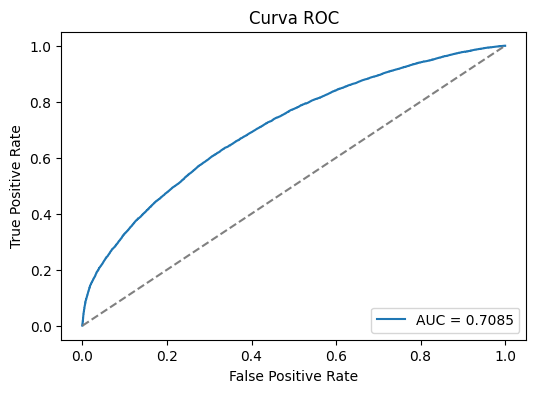

In [90]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score   = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Dibujamos la curva y vemos un AUC≈0.71, muy superior al 0.5 del azar, lo que confirma que el modelo discrimina razonablemente bien.

Quiero ver cómo reparte el modelo su grado de certeza, es decir, las probabilidades de que cada muestra pertenezca a la clase positiva (HasDetections=1).

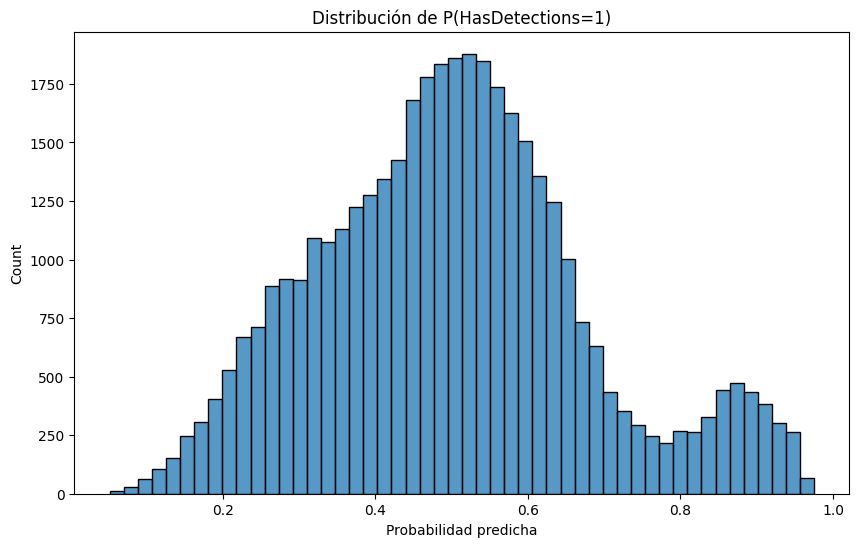

In [94]:
plt.figure(figsize=(10,6))
sns.histplot(y_proba, bins=50)
plt.title("Distribución de P(HasDetections=1)")
plt.xlabel("Probabilidad predicha")
plt.show()

La mayoría de las predicciones se agrupan alrededor de la zona media (~0.4–0.6), mostrando que el modelo suele ser “indeciso”.

Hay un pico claro hacia probabilidades altas (~0.8–0.9), donde está más seguro de detecciones positivas.

# Interpretación del modelo

Hemos entrenado y ajustado nuestro XGBoost y ahora queremos interpretar cómo influyen las variables en sus predicciones.

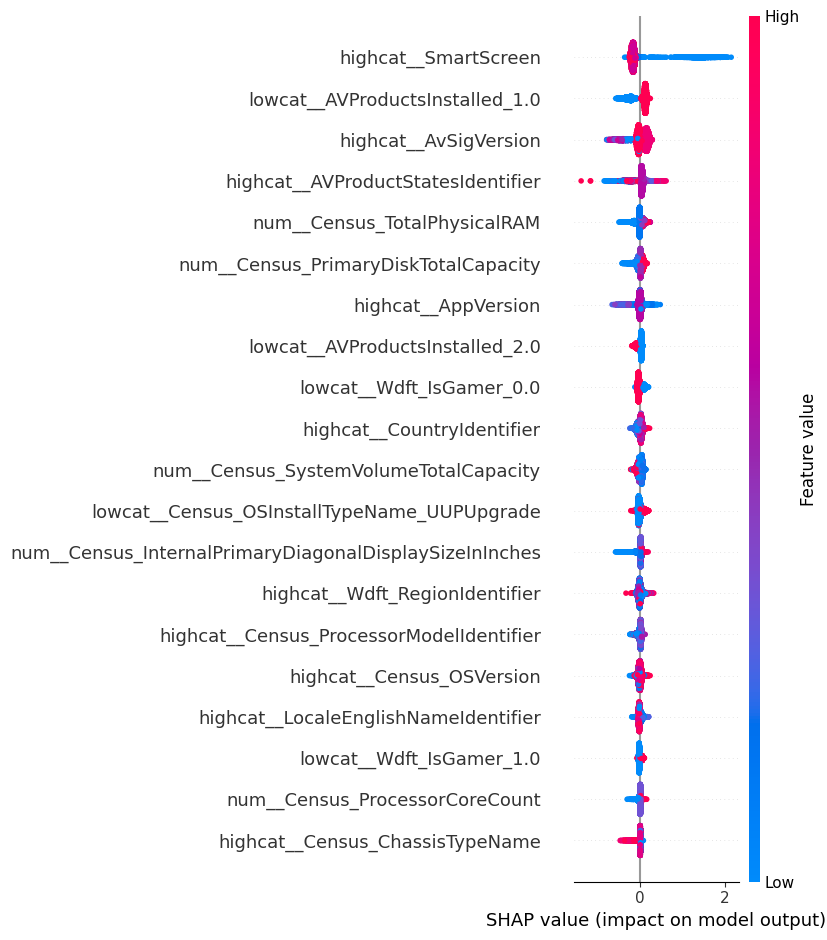

In [83]:
import shap

preprocessor, model = best_clf.named_steps['preproc'], best_clf.named_steps['model']

X_sample = preprocessor.transform(X_test.sample(10000, random_state=42))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=preprocessor.get_feature_names_out())

SmartScreen (feature highcat__SmartScreen) es la más decisiva.

Instalar exactamente 1 antivirus (lowcat__AVProductsInstalled_1.0) también eleva la probabilidad de detección.

Otras como RAM total o tipo de disco tienen impacto, pero mucho menor.

Este gráfico nos ayuda a ver rápidamente qué atributos “empujan” más al modelo hacia HasDetections=1.

Muestra la importancia media (media de |SHAP|) de cada variable: cuánto “empuja” de media cada feature la salida del modelo.

Hemos destacado las 8 más influyentes y agrupado el resto en “Sum of 108 other features”.

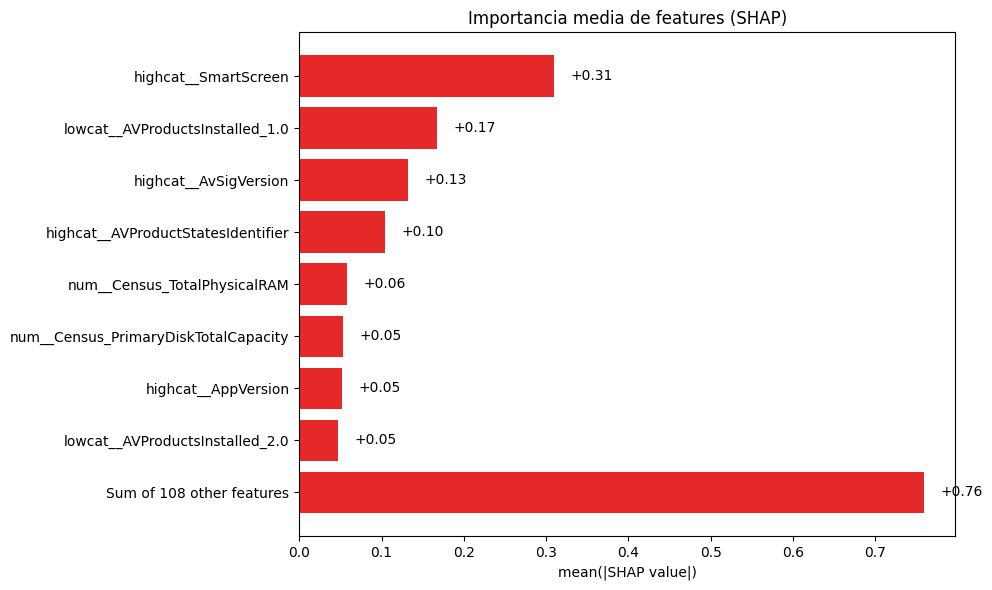

In [ ]:
feature_names = preprocessor.get_feature_names_out()

mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_imp = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

top_n = 8
top = shap_imp.iloc[:top_n]
others_sum = shap_imp.iloc[top_n:]['mean_abs_shap'].sum()
others = pd.DataFrame({
    'feature': ['Sum of {} other features'.format(len(shap_imp) - top_n)],
    'mean_abs_shap': [others_sum]
})
plot_df = pd.concat([top, others], ignore_index=True)

plt.figure(figsize=(10,6))
plt.barh(plot_df['feature'][::-1], plot_df['mean_abs_shap'][::-1], color='#e52929')
for i, v in enumerate(plot_df['mean_abs_shap'][::-1]):
    plt.text(v + 0.02, i, f"+{v:.2f}", va='center')
plt.xlabel("mean(|SHAP value|)")
plt.title("Importancia media de features (SHAP)")
plt.tight_layout()
plt.show()

highcat__SmartScreen es con gran diferencia la variable que más aporta (+0.31).

Le siguen el número de antivirus instalados (lowcat__AVProductsInstalled_1.0, +0.17) y versiones de definición (highcat__AvSigVersion, +0.13).

El bloque “Sum of 108 other features” suma +0.76, lo que indica que hay muchas variables con efecto pequeño pero acumulado importante.

# Conclusion

El modelo definitivo que hemos desplegado es un XGBoost integrado en un pipeline que escala las variables numéricas y codifica las categóricas de forma eficiente (One-Hot sparse para baja cardinalidad, ordinal para alta). En validación cruzada estratificada a 5 pliegues obtuvo un ROC AUC medio de 0.7075 con desviación estándar muy reducida, y en el conjunto de test hold-out logró un ROC AUC de 0.6478, lo que refleja un comportamiento consistente pero de capacidad moderada para diferenciar entre detecciones positivas y negativas.

Estos resultados sugieren que el modelo está limitado por las transformaciones actuales y la alta dimensionalidad del dataset. Para avanzar, convendría profundizar en el feature engineering (por ejemplo, generar ratios como “RAM por núcleo” o aplicar transformaciones logarítmicas a las capacidades de disco), así como simplificar o resumir las variables categóricas de muy alta cardinalidad. También podría explorarse un ensamblado ligero (stacking de XGBoost y LightGBM) o calibrar las probabilidades de salida para mejorar la utilidad práctica de las predicciones. En resumen, este pipeline ofrece un punto de partida sólido (~0.65–0.70 AUC) con margen claro para optimizar las características y afinar el modelo.